Reference states: (1) GHZ state, (2) cluster state, and (3) product state |+...+>  AND basic routines

In [ ]:
using ITensors, ITensorMPS, Optim, LinearAlgebra, Printf, Random

# Define basic operators
function pauli_operators(s)
    sigmax = 2 * op("Sx", s)
    sigmay = 2 * op("Sy", s)
    sigmaz = 2 * op("Sz", s)
    id = op("Id", s)
    return [id, sigmax, sigmay, sigmaz]  # σ⁰, σˣ, σʸ, σᶻ
end

# Define the Hadamard gate
function hadamard(s)
    sx = op("Sx", s)
    sz = op("Sz", s)
    h = (sx + sz) * sqrt(2.0)
    return h
end

N = 5 #number of qubits
sites = siteinds("S=1/2", N)
psi0 = productMPS(sites, "Up") #all in the up-state (|0>)
#act with Hadamard on the first site
site_index = 1
h = hadamard(sites[site_index])
# Apply the gate to the MPS - use an array for the site index
psi0 = apply(h, psi0, [site_index])  # Note the [site_index] array syntax here
psi0 = normalize(psi0);

# Create parameterized two-qubit unitary, acting on sites i and i + 1
function create_unitary(sites, i, params)
    # params has 15 parameters that encode the unitary
    
    s1 = sites[i]
    s2 = sites[i+1]
    
    # Get Pauli operators for both sites
    ops1 = pauli_operators(s1)  # [I, σx, σy, σz] for site 1
    ops2 = pauli_operators(s2)  # [I, σx, σy, σz] for site 2
    
    # Initialize the generator of the unitary (Hermitian operator)
    generator = 0.0 * ops1[1] * ops2[1]#pick custom phase 
    
    # Two-qubit σᵃ⊗σᵇ terms
    param_idx = 1
    for a in 2:4, b in 2:4
        term = ops1[a] * ops2[b]
        generator += -im * params[param_idx] * term
        param_idx += 1
    end

    #Single-qubit σᵃ⊗I terms
    for a in 2:4
        term = ops1[a] * ops2[1]
        generator += -im * params[param_idx] * term
        param_idx += 1
    end

    #Single-qubit I⊗σᵇ terms
    for b in 2:4
        term = ops1[1] * ops2[b]
        generator += -im * params[param_idx] * term
        param_idx += 1
    end

    return exp(generator)
end

# Apply the ladder circuit to a given MPS psi
function apply_circuit(psi, sites, params)
    N = length(sites)
    psi_evolved = deepcopy(psi)
    # Apply unitaries sequentially: (1,2), (2,3), ...
    for i in 1:(N-1)
        U = create_unitary(sites, i, params)
        psi_evolved = apply(U, psi_evolved, [i, i+1]; maxdim=2)
        normalize!(psi_evolved)
    end   
    return psi_evolved
end

# Fidelity optimization
function optimize_circuit_state(psi0, sites, initial_params, state; max_iter=1000)
    N = length(sites)

    function objective(p)
        psi = apply_circuit(psi0, sites, p)
        cost = -abs2(inner(psi, state))
        # # Print progress
        # if rand() < 0.1  # Only print occasionally to avoid too much output
        #     println("Current cost: $cost")
        # end
        return cost
    end
    
    # Run the optimization
    println("Starting optimization...")
    result = optimize(
        objective,
        initial_params,
        BFGS(),
        Optim.Options(iterations=max_iter, show_trace=true)
    )
    
    opt_params = Optim.minimizer(result)
    
    println("Optimization complete!")
    println("Final cost: $objective(opt_params)")

    return opt_params
end

params_GHZ = zeros(15)
params_GHZ[7] = pi / 4
params_GHZ[12] = - pi / 4
params_GHZ[13] = - pi / 4
psi = apply_circuit(psi0, sites, params_GHZ)
# Create |00...0> state
state_0 = productMPS(sites, "Up")
# Create |11...1> state
state_1 = productMPS(sites, "Dn")
# Create the superposition: (|00...0> + |11...1>)/sqrt(2)
ghz_state = add(state_0, state_1)
normalize!(ghz_state)
fidelity_ghz = abs2(inner(psi, ghz_state))
println("Fidelity wrt to GHZ = $(round(fidelity_ghz, digits=4))")

params_plus = zeros(15)
params_plus[14] = pi / 4
psi = apply_circuit(psi0, sites, params_plus)
# Create |+>⊗|+>...⊗|+> state
plus_state = MPS(sites, n -> "X+")
fidelity_plus = abs2(inner(psi, plus_state))
println("Fidelity wrt to |+>⊗|+>...⊗|+> = $(round(fidelity_plus, digits=4))")


# First create |+>⊗|+>...⊗|+> state
cluster_state = MPS(sites, n -> "X+")
# Apply CZ gates between neighboring qubits
for j in 1:(length(sites)-1)
    # Create CZ gate between sites j and j+1
    s1 = sites[j]
    s2 = sites[j+1]
    
    # CZ = |00><00| + |01><01| + |10><10| - |11><11|
    # In computational basis, this corresponds to a phase flip when both qubits are in |1> state
    proj00 = op("ProjUp", s1) * op("ProjUp", s2)
    proj01 = op("ProjUp", s1) * op("ProjDn", s2)
    proj10 = op("ProjDn", s1) * op("ProjUp", s2)
    proj11 = op("ProjDn", s1) * op("ProjDn", s2)
    
    cz = proj00 + proj01 + proj10 - proj11
    
    # Apply the gate
    cluster_state = apply(cz, cluster_state, [j, j+1])
    normalize!(cluster_state)
end

Random.seed!(123) 
params = 0.01 * rand(15)
params_cluster = optimize_circuit_state(psi0, sites, params, cluster_state)
psi = apply_circuit(psi0, sites, params_cluster)
# Calculate fidelity with cluster state
fidelity_cluster = abs2(inner(psi, cluster_state))
println("Fidelity wrt to cluster_state = $(round(fidelity_cluster, digits=4))")


Fidelity wrt to GHZ = 1.0
Fidelity wrt to |+>⊗|+>...⊗|+> = 1.0
Starting optimization...
Iter     Function value   Gradient norm 
     0    -6.500969e-02     5.182088e-01
 * time: 0.012733936309814453
     1    -2.807026e-01     9.139560e-01
 * time: 0.5180258750915527
     2    -3.371869e-01     7.490078e-01
 * time: 0.8997788429260254
     3    -5.768574e-01     1.149496e+00
 * time: 1.0361688137054443
     4    -7.105286e-01     9.657887e-01
 * time: 1.1500229835510254
     5    -7.780254e-01     6.889875e-01
 * time: 1.232839822769165
     6    -8.391100e-01     8.607910e-01
 * time: 1.3003928661346436
     7    -9.665258e-01     2.935222e-01
 * time: 1.347743034362793
     8    -9.923763e-01     1.857557e-01
 * time: 1.3918969631195068
     9    -9.977295e-01     9.766606e-02
 * time: 1.4379169940948486
    10    -9.996368e-01     5.610472e-02
 * time: 1.4853918552398682
    11    -9.999113e-01     1.877830e-02
 * time: 1.5304539203643799
    12    -9.999911e-01     4.418309e-03
 *

optimize_circuit (generic function with 1 method)

In [ ]:
# Function to optimize circuit with multiple initial conditions
function optimize_with_multiple_inits(psi0, sites, g, num_inits=5; 
    max_iter=500, 
    params_GHZ=nothing,
    params_cluster=nothing, 
    params_plus=nothing, 
    params_prev=nothing)

    best_cost = 1000
    best_params = zeros(15)
    operators_tuple = prepare_operators(sites)

    initial_params = params_GHZ
    params = optimize_circuit(psi0, sites, g, initial_params; max_iter=max_iter)
    cost = cost_function_params(params, psi0, sites, operators_tuple, g)
    if cost <= best_cost
        best_cost = cost
        best_params = params
    end

    initial_params = params_cluster
    params = optimize_circuit(psi0, sites, g, initial_params; max_iter=max_iter)
    cost = cost_function_params(params, psi0, sites, operators_tuple, g)
    if cost <= best_cost
        best_cost = cost
        best_params = params
    end

    # initial_params = params_plus
    # params = optimize_circuit(psi0, sites, g, initial_params; max_iter=max_iter)
    # cost = cost_function_params(params, psi0, sites, operators_tuple, g)
    # if cost <= best_cost
    #     best_cost = cost
    #     best_params = params
    # end

    if params_prev !== nothing
        initial_params = params_prev
        params = optimize_circuit(psi0, sites, g, initial_params; max_iter=max_iter)
        cost = cost_function_params(params, psi0, sites, operators_tuple, g)
        if cost < best_cost
            best_cost = cost
            best_params = params
        end
    end

    # for i in 1:num_inits
    #     initial_params = 0.01 * randn(15)
    #     params = optimize_circuit(psi0, sites, g, initial_params; max_iter=max_iter)
    #     cost = cost_function_params(params, psi0, sites, operators_tuple, g)
    #     if cost < best_cost
    #         best_cost = cost
    #         best_params = params
    #     end
    # end
    
    return best_params
end


optimize_with_multiple_inits (generic function with 2 methods)

In [ ]:
g_values = range(-1.0, 1.0, 40)
num_inits = 5
max_iter = 500
all_params = []
all_costs = []
params_prev = params_cluster

operators_tuple = prepare_operators(sites)
X_string_mpo, O_string_mpo, ZZ_term_mpo = operators_tuple

# Loop over g values
for g in g_values
    println("\n=== g = $g ===")
    
    # Optimize with multiple initial conditions
    best_params = optimize_with_multiple_inits(
        psi0, sites, g, num_inits; 
        max_iter=max_iter,
        params_GHZ=params_GHZ,
        params_cluster=params_cluster,
        params_plus=params_plus,
        params_prev=params_prev
    )
    psi = apply_circuit(psi0, sites, best_params)
    best_cost = cost_function(psi, X_string_mpo, O_string_mpo, ZZ_term_mpo, N, g)
    # Store results
    push!(all_params, best_params)
    push!(all_costs, best_cost)
    # Update params_prev for next iteration
    params_prev = best_params
end


=== g = -1.0 ===
Optimizing for g = -1.0...
Iter     Function value   Gradient norm 
     0     1.917353e-32     1.167199e-11
 * time: 5.3882598876953125e-5
Optimizing for g = -1.0...
Iter     Function value   Gradient norm 
     0    -1.000000e+00     4.070207e-09
 * time: 5.7220458984375e-5
Optimizing for g = -1.0...
Iter     Function value   Gradient norm 
     0    -1.000000e+00     4.070207e-09
 * time: 4.291534423828125e-5

=== g = -0.9487179487179487 ===
Optimizing for g = -0.9487179487179487...
Iter     Function value   Gradient norm 
     0    -2.564103e-02     1.174539e-11
 * time: 3.981590270996094e-5
Optimizing for g = -0.9487179487179487...
Iter     Function value   Gradient norm 
     0    -9.743590e-01     4.945162e-02
 * time: 4.38690185546875e-5
     1    -9.745482e-01     1.664877e-02
 * time: 0.056199073791503906
     2    -9.746337e-01     6.629402e-03
 * time: 0.1146860122680664
     3    -9.746381e-01     5.687680e-03
 * time: 0.18170785903930664
     4    -9.746

In [ ]:
all_costs = []
all_X_exp = []
all_O_exp = []
all_ZZ_exp = []

fidelity_ghz = []
fidelity_cluster = []

for (i, g) in enumerate(g_values)
    println("\n=== g = $g ===")
    
    # Optimize with multiple initial conditions
    best_params = all_params[i]
    
    psi = apply_circuit(psi0, sites, best_params)
    best_cost = cost_function(psi, X_string_mpo, O_string_mpo, ZZ_term_mpo, N, g)
    X_exp = real(inner(psi', X_string_mpo, psi))
    O_exp = real(inner(psi', O_string_mpo, psi))
    ZZ_exp = real(inner(psi', ZZ_term_mpo, psi))

    push!(fidelity_ghz, abs2(inner(psi, ghz_state)))
    push!(fidelity_cluster, abs2(inner(psi, cluster_state)))

    # Store results
    push!(all_costs, best_cost)
    push!(all_X_exp, X_exp)
    push!(all_O_exp, O_exp)
    push!(all_ZZ_exp, ZZ_exp / (N - 1))
    
    # Update params_prev for next iteration
    params_prev = best_params
end




=== g = -1.0 ===

=== g = -0.9487179487179487 ===

=== g = -0.8974358974358975 ===

=== g = -0.8461538461538461 ===

=== g = -0.7948717948717948 ===

=== g = -0.7435897435897436 ===

=== g = -0.6923076923076923 ===

=== g = -0.6410256410256411 ===

=== g = -0.5897435897435898 ===

=== g = -0.5384615384615384 ===

=== g = -0.48717948717948717 ===

=== g = -0.4358974358974359 ===

=== g = -0.38461538461538464 ===

=== g = -0.3333333333333333 ===

=== g = -0.28205128205128205 ===

=== g = -0.23076923076923078 ===

=== g = -0.1794871794871795 ===

=== g = -0.1282051282051282 ===

=== g = -0.07692307692307693 ===

=== g = -0.02564102564102564 ===

=== g = 0.02564102564102564 ===

=== g = 0.07692307692307693 ===

=== g = 0.1282051282051282 ===

=== g = 0.1794871794871795 ===

=== g = 0.23076923076923078 ===

=== g = 0.28205128205128205 ===

=== g = 0.3333333333333333 ===

=== g = 0.38461538461538464 ===

=== g = 0.4358974358974359 ===

=== g = 0.48717948717948717 ===

=== g = 0.538461538461

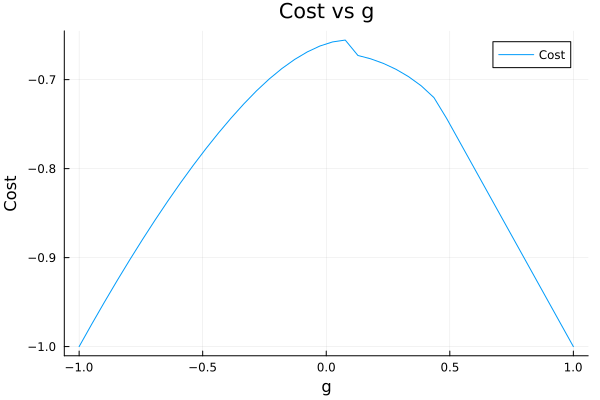

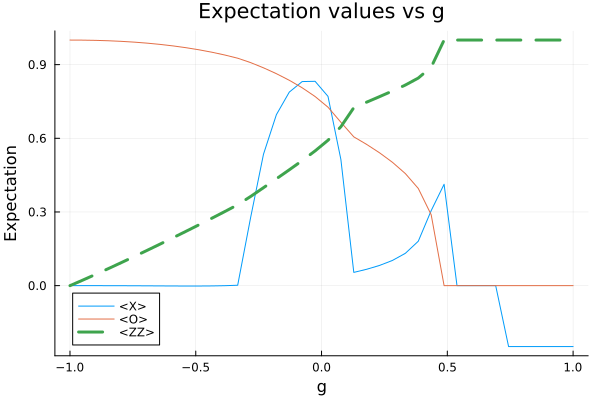

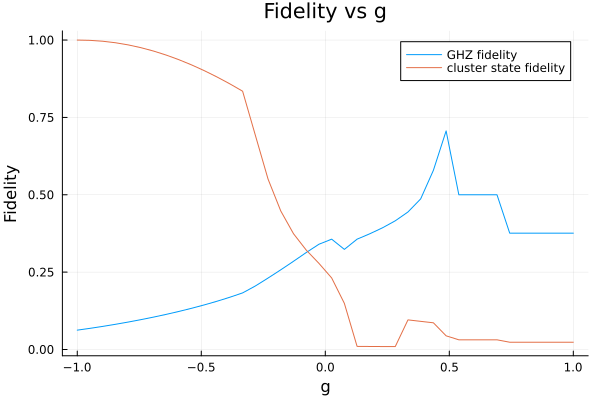

In [ ]:
using Plots
 # Create plots
p1 = plot(g_values, all_costs, label="Cost", title="Cost vs g", xlabel="g", ylabel="Cost");
p2 = plot(g_values, all_X_exp, label="<X>", title="Expectation values vs g", xlabel="g", ylabel="Expectation",linewidth=1);
plot!(p2, g_values, (-1)^N * all_O_exp, label="<O>",linewidth=1);
plot!(p2, g_values, all_ZZ_exp, label="<ZZ>",linestyle=:dash,linewidth=3);

p3 = plot(g_values, fidelity_ghz, label="GHZ fidelity", title="Fidelity vs g", xlabel="g", ylabel="Fidelity");
plot!(p3, g_values, fidelity_cluster, label="cluster state fidelity");

display(p1)
display(p2)
display(p3)

Hamiltonian learning step